# Training

In [14]:
import torch
import random
!pip install transformers

# from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import json

from matplotlib import pyplot as plt

from ipynb.fs.full.read_in_data import read_in_data

from transforms import train_transforms
from dataset import ContrastiveLearningDataset

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

selenium 4.1.5 requires urllib3[secure,socks]~=1.26, but you'll have urllib3 1.25.11 which is incompatible.
huggingface-hub 0.7.0 requires packaging>=20.9, but you'll have packaging 20.4 which is incompatible.


## Loading data

In [15]:
with open("../public_dataset/reference_images_part1.json") as f:
    ref_json = json.load(f)

dir_str = "../public_dataset/reference_images_part1"
df = read_in_data(dir_str, ref_json)

df = df.sort_values('category_id')
df = df.reset_index(drop=True)
df.head()

,id,image_id,bbox,category_id,img
0,155,33,"[116, 97, 411, 126]",1,<PIL.Image.Image image mode=RGB size=411x126 a...
1,33,6,"[573, 246, 164, 298]",1,<PIL.Image.Image image mode=RGB size=164x298 a...
2,32,6,"[114, 269, 363, 223]",1,<PIL.Image.Image image mode=RGB size=363x223 a...
3,30,6,"[622, 218, 374, 220]",1,<PIL.Image.Image image mode=RGB size=374x220 a...
4,29,6,"[743, 486, 354, 132]",1,<PIL.Image.Image image mode=RGB size=354x132 a...


In [16]:
from torchvision.transforms import transforms as T

1
torch.Size([3, 224, 224])


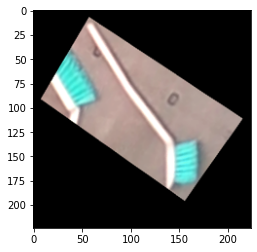

In [17]:
id = 1
img = df['img'][id]
print(df['category_id'][id])

img = train_transforms(img)
img = T.Resize(224)(img)

print(img.shape)

plt.imshow(img.permute(1, 2, 0))

In [18]:
images = df['img']
labels = df['category_id']

val_labels = [4, 10]
val_ids = ~labels.isin(val_labels) # TODO

val_images = images[val_ids].reset_index(drop=True)
val_labels = labels[val_ids].reset_index(drop=True)

train_ids = ~val_ids

train_images = images[train_ids].reset_index(drop=True)
train_labels = labels[train_ids].reset_index(drop=True)

In [19]:
train_dataset = ContrastiveLearningDataset(train_images, train_labels, train_transforms)

(1, 0.07407407407407407)

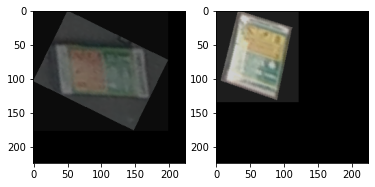

In [20]:
id_ = random.randrange(0, len(train_dataset))

image_1, image_2, sign, weight = train_dataset[id_]

f, axarr = plt.subplots(1,2) 

axarr[0].imshow(image_1.permute(1, 2, 0))
axarr[1].imshow(image_2.permute(1, 2, 0))

sign, weight

In [21]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True,
)

## Training loop

In [22]:
EPOCHS = 10

In [23]:
from ipynb.fs.full.fb_model_extractor import DeiTForImageClassificationWithTeacher
from transformers import AutoFeatureExtractor


torch.Size([1, 384])


In [24]:
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-small-distilled-patch16-224') # TODO to nie jest dotrenowywane
model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-small-distilled-patch16-224')
optimizer = torch.optim.Adam(model.parameters())

In [66]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

def contrastive_learning_loss(v_1, v_2, weight, sign):
    cos_sim = cos(v_1, v_2)
    loss = - weight * cos_sim * sign
    return loss.mean()

def preprocess_images(images):

    examples = dict()
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    inputs = feature_extractor(images=image[0])
    examples['pixel_values'] = inputs['pixel_values']

    return examples


In [ ]:
import numpy as np
for epoch in range(EPOCHS):
    losses = []
    for i, data in enumerate(train_loader, 0):
        image_1, image_2, sign, weight = data
        images_1 = [np.array(image, dtype=np.uint8) for image in image_1]
        images_2 = [np.array(image, dtype=np.uint8) for image in image_2]
        
        test = feature_extractor(images_1, return_tensors='pt')
        print(torch.max(image_1))
#         print(test.keys())
#         keyed={'pixel_values' : torch.tensor(np.array(test['pixel_values']))}
#         print(keyed)
        v_1 = model(**test)
        v_2 = model(**feature_extractor(images_2, return_tensors='pt'))
        
        loss = contrastive_learning_loss(v_1, v_2, weight, sign)
        print(loss)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
        # YOUR CODE HERE
        
        # TODO: walidacja, wypisywanie lossów itd
        # END YOUR CODE

tensor(255, dtype=torch.uint8)
tensor(-0.0046, dtype=torch.float64, grad_fn=<MeanBackward0>)
